Loading data...
Dataset shape after skipping bad lines: (4898430, 42)
Creating binary labels...
Class distribution before balancing:
binary_label
attack    3925650
normal     972780
Name: count, dtype: int64
Preparing features and target...
Splitting data into training and testing sets...
Training set shape before balancing: (3428901, 41)
Preprocessing training data...
Applying SMOTE to balance classes...
Training set shape after balancing: (5495910, 121)
Class distribution after balancing: binary_label
1    2747955
0    2747955
Name: count, dtype: int64
Creating and training Random Forest model...
Model training completed.

Preprocessing test data for evaluation...
Evaluating model...
Accuracy: 0.9997
F1 Score: 0.9998

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    291834
      Attack       1.00      1.00      1.00   1177695

    accuracy                           1.00   1469529
   macro avg       1.00      

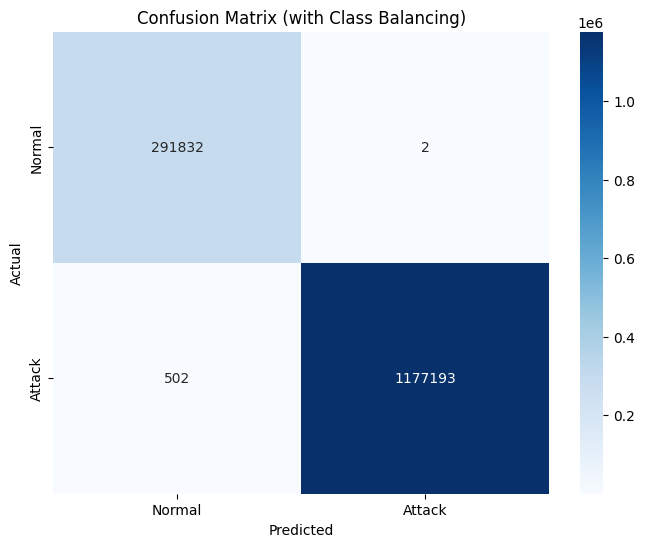

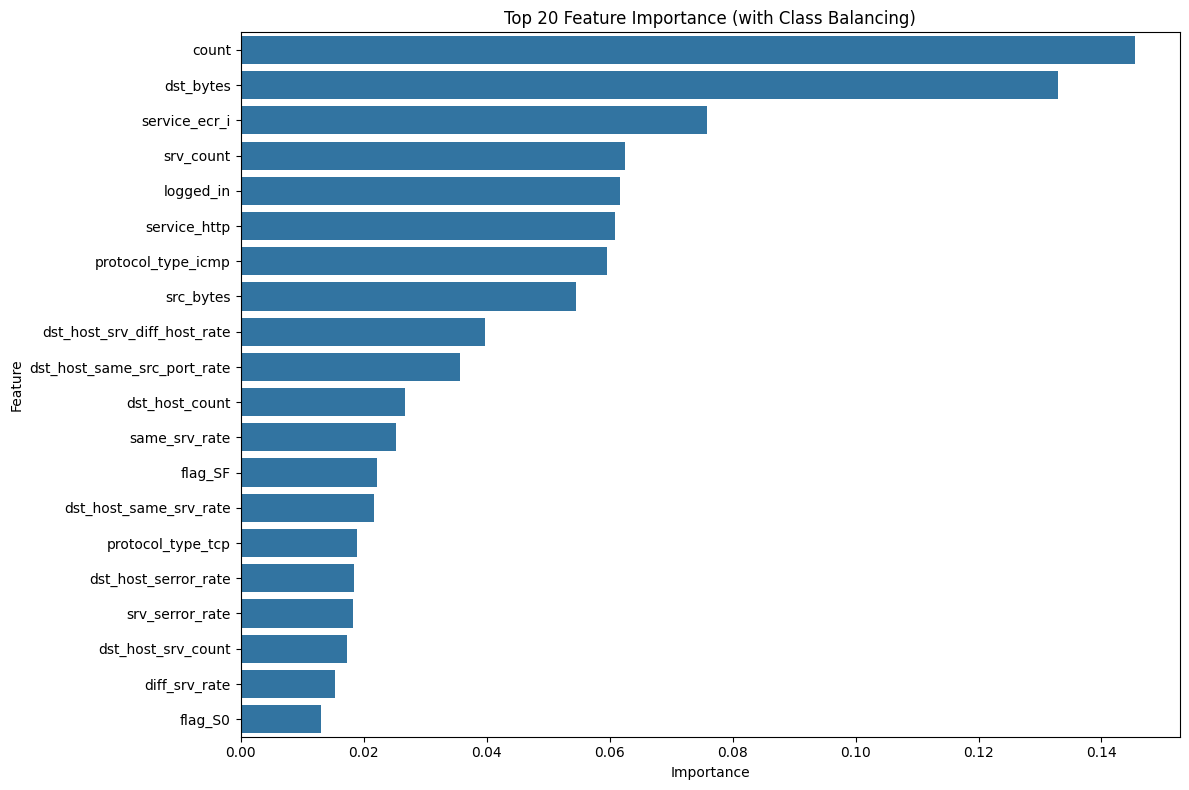

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  # Added for handling class imbalance

# Define column names based on the dataset description
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_hot_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]

def main():
    try:
        # Step 1: Load data
        print("Loading data...")
        # Updated to handle txt file with comma-separated values and no header
        data = pd.read_csv('kddcup.data.txt', header=None, names=column_names, sep=',', on_bad_lines='skip')
        print(f"Dataset shape after skipping bad lines: {data.shape}")
        
        # Step 2: Create binary labels (attack vs normal)
        print("Creating binary labels...")
        data['binary_label'] = data['label'].apply(
            lambda x: 'normal' if x == 'normal.' else 'attack'
        )
        print(f"Class distribution before balancing:\n{data['binary_label'].value_counts()}")
        
        # Step 3: Split features and target
        print("Preparing features and target...")
        # Identify categorical and numerical features
        categorical_features = ['protocol_type', 'service', 'flag']
        numerical_features = [col for col in data.columns 
                             if col not in categorical_features + ['label', 'binary_label']]
        
        # Create preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])
        
        # Prepare X (features) and y (target)
        X = data.drop(['label', 'binary_label'], axis=1)
        y = (data['binary_label'] == 'attack').astype(int)  # 1 for attack, 0 for normal
        
        # Step 4: Split the data into training and testing sets
        print("Splitting data into training and testing sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        print(f"Training set shape before balancing: {X_train.shape}")
        
        # Step 5: Apply preprocessing to training data first
        print("Preprocessing training data...")
        # We need to apply preprocessing before SMOTE
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        numerical_transformer = StandardScaler()
        
        cat_cols = X_train[categorical_features]
        num_cols = X_train[numerical_features]
        
        # Apply transformations
        cat_processed = categorical_transformer.fit_transform(cat_cols)
        num_processed = numerical_transformer.fit_transform(num_cols)
        
        # Convert to array and concatenate
        cat_array = cat_processed.toarray()
        X_train_processed = np.hstack((num_processed, cat_array))
        
        # Step 6: Apply SMOTE to balance classes
        print("Applying SMOTE to balance classes...")
        # Only apply SMOTE to the training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
        
        print(f"Training set shape after balancing: {X_train_resampled.shape}")
        print(f"Class distribution after balancing: {pd.Series(y_train_resampled).value_counts()}")
        
        # Step 7: Create and train the Random Forest model
        print("Creating and training Random Forest model...")
        # We'll use class_weight='balanced' as an alternative approach to handle imbalance
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            # We already used SMOTE, but adding class_weight as additional protection
            class_weight='balanced',  
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_train_resampled, y_train_resampled)
        print("Model training completed.")
        
        # Step 8: Preprocess test data for evaluation
        print("\nPreprocessing test data for evaluation...")
        cat_test = categorical_transformer.transform(X_test[categorical_features])
        num_test = numerical_transformer.transform(X_test[numerical_features])
        
        cat_test_array = cat_test.toarray()
        X_test_processed = np.hstack((num_test, cat_test_array))
        
        # Step 9: Evaluate the model
        print("Evaluating model...")
        y_pred = model.predict(X_test_processed)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")  # F1 score is useful for imbalanced datasets
        
        # Display classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))
        
        # Create and plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Normal', 'Attack'],
                   yticklabels=['Normal', 'Attack'])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix (with Class Balancing)')
        plt.savefig('confusion_matrix_balanced.png')
        print("Confusion matrix saved as 'confusion_matrix_balanced.png'")
        
        # Step 10: Analyze feature importance
        print("\nAnalyzing feature importance...")
        # We need to get feature names from the transformers
        ohe_feature_names = categorical_transformer.get_feature_names_out(categorical_features)
        feature_names = np.concatenate([numerical_features, ohe_feature_names])
        
        # Get feature importances
        importances = model.feature_importances_
        
        # Create a DataFrame for better visualization
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # Sort by importance
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        # Display top 20 most important features
        print("\nTop 20 Most Important Features:")
        print(feature_importance.head(20))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title('Top 20 Feature Importance (with Class Balancing)')
        plt.tight_layout()
        plt.savefig('feature_importance_balanced.png')
        print("Feature importance plot saved as 'feature_importance_balanced.png'")
        
        print("\nModel training and evaluation with class balancing completed successfully.")
        
    except Exception as e:
        print(f"An error occurred during execution: {e}")

if __name__ == "__main__":
    main()